In [71]:
!git clone https://github.com/airtlab/ConvLSTM4AD

!gdown --id 1FIc_Q47m6F0HjOuURbgjrRihbc9_uced -O ConvLSTM4AD/bestmodel.h5

#from google.colab import drive
#drive.mount('/content/drive')

fatal: destination path 'ConvLSTM4AD' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1FIc_Q47m6F0HjOuURbgjrRihbc9_uced
To: /content/ConvLSTM4AD/bestmodel.h5
2.11GB [00:13, 158MB/s]


In [72]:
#!pip show tensorflow
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn import model_selection
import os
import nibabel as nib
import cv2
import numpy as np
!pip install simpleitk
import SimpleITK as sitk


img_path = "/content/ConvLSTM4AD/Merged_dataset/Dataset"
img_height, img_width = 256, 256 
seq_len = 5


# Read
def read_img(img_path):
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path)) 

# Resample to 1 mm
def resample_img(itk_image, out_spacing=[1, 1, 1], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
    return resample.Execute(itk_image)

def preprocess(img, out_shape=None):
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Input normalization
    mean = img.mean() 
    std = img.std() 
    return (img - mean) / std


X = []
Y = []

d = img_path
classes = ["AD","CN"]
classes_list = os.listdir(d) 
sorted(classes_list)
print(classes_list[0]) 
print(classes_list[1]) 

full_path = os.path.join(d,classes_list[0]) # AD
for p2 in os.listdir(full_path): 
  p3 = os.path.join(full_path,p2) 
  my_img = nib.load(p3) 
  nii_data = my_img.get_fdata() 
  my_img.uncache()
  del my_img
  temp = []
  for i in range(0,5): 
    temp.append(cv2.resize(nii_data[:,:,i],(256,256)))
  X.append(temp)
  y = [0]*len(classes_list)
  y[1] = 1
  Y.append(y) # label [0,1]

full_path1 = os.path.join(d,classes_list[1]) # CN
for p2 in os.listdir(full_path1): 
  p3 = os.path.join(full_path1,p2) 
  my_img = nib.load(p3) 
  nii_data = my_img.get_fdata() 
  my_img.uncache()
  del my_img
  temp = []
  for i in range(0,5): 
    temp.append(cv2.resize(nii_data[:,:,i],(256,256)))
  X.append(temp)
  y = [0]*len(classes_list)
  y[0] = 1
  Y.append(y) # label [1,0] 

['AD', 'CN']
AD
CN


In [73]:
X = np.asarray(X)
Y = np.asarray(Y)

X = X[...,np.newaxis]
print(X.shape)

(427, 5, 256, 256, 1)


In [74]:
X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, test_size = 0.20, shuffle = True, random_state = 0)

print("Number of training samples: " + str(len(X_train)))
print("Number of test samples: " + str(len(X_test)))

del X
del Y

Number of training samples: 341
Number of test samples: 86


In [75]:
model = tf.keras.models.load_model('/content/ConvLSTM4AD/bestmodel.h5') 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 254, 254, 32)      38144     
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 254, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               528515328 
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 528,553,986
Trainable params: 528,553,986
Non-trainable params: 0
________________________________________

In [76]:
# Classification report

from sklearn.metrics import classification_report

print(X_test.shape)

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

print(classification_report(Y_test,y_pred))

(86, 5, 256, 256, 1)
              precision    recall  f1-score   support

           0       0.97      0.76      0.85        38
           1       0.84      0.98      0.90        48

    accuracy                           0.88        86
   macro avg       0.90      0.87      0.88        86
weighted avg       0.90      0.88      0.88        86



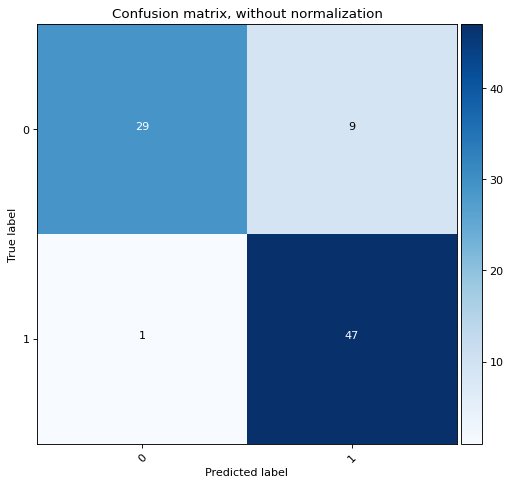

In [77]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from itertools import cycle
from scipy import interp
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6), dpi=80)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

class_names = {0,1} 

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,y_pred)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()